# Force Quant

## Install dependencies

In [15]:
%%capture
%pip install -U langchain_core langgraph requests beautifulsoup4

## Import packages

In [13]:
import operator
from typing import Annotated, Any, Sequence
from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
import requests # used to access wikipedia
from bs4 import BeautifulSoup # used to process HTML from wikipedia
from IPython.display import display, HTML, Image
import os # for referencing environment variables
from dotenv import load_dotenv # for loading environment variables 
import yfinance as yf # used to obtain P/E ratios


## Environment Variables

In [28]:
load_dotenv() # load environment variables from .env file

## State class

In [3]:
class State(TypedDict):
    ticker: str
    messages: Annotated[list, operator.add]

### _dummy node_

In [4]:
def dummy_node(state: State) -> State:
    return {"messages": ["intermediate message"]}

## Node and edge functions

In [5]:
def is_in_snp(ticker: str) -> bool:
    ''' 
        Checks if the given ticker is a member of the S&P 500 index.
        Disclaimer: uses wikipedia. A production version of this 
        function should use a more reliable source.
    '''
    # Fetch the S&P 500 list from Wikipedia
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the table containing the S&P 500 tickers
    table = soup.find('table', {'id': 'constituents'})
    rows = table.find_all('tr')[1:]  # Skip the header row

    # Extract tickers from the table
    sp500_tickers = [row.find_all('td')[0].text.strip() for row in rows]

    # Check if the given ticker is in the S&P 500 list
    return ticker.upper() in sp500_tickers

def is_evaluation_valid(state: State) -> bool:
    pass

def is_in_snp(state: State) -> bool:
    pass
    
def validate_snp(state: State) -> Sequence[str]:
    if is_in_snp(state["ticker"]):
        return [
            "Calculate Current Premium", 
            "Estimate Future Premium"
        ]
    else:
        return [END]

def get_pe_ratio(ticker: str, useForward = False) -> float:
    '''
        Returns the forward P/E ratio of the given ticker.
    '''
    security = yf.Ticker(ticker)
    metric = 'forwardPE' if useForward else 'trailingPE'
    pe_ratio = security.info[metric]
    return pe_ratio

def get_current_premium(ticker: str) -> float:
    '''
        Returns the current premium of the given ticker,
        measured in terms of the P/E ratio relative to 
        the average for the S&P 500 index. Note that forward 
        earnings are used for individual securities but trailing 
        earnings are used for the S&P 500 index. This is based 
        on lack of data availability from the source used. 
        A production environment should use consistent multples.
    '''
    pe_ratio_ticker = get_pe_ratio(ticker, useForward = True)
    pe_ratio_snp = get_pe_ratio('SPY')
    current_premium = pe_ratio_ticker / pe_ratio_snp - 1
    return current_premium


## Calculate Current Premium Graph

In [6]:
cp_builder = StateGraph(State)
cp_builder.add_node("Get Earnings Multiple", dummy_node)
cp_builder.add_node("Calculate Current Premium", dummy_node)

cp_builder.add_edge(START, "Get Earnings Multiple")
cp_builder.add_edge("Get Earnings Multiple", "Calculate Current Premium")
cp_builder.add_edge("Calculate Current Premium", END)

cp_graph = cp_builder.compile()

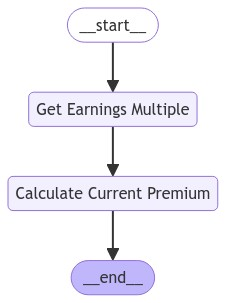

In [7]:
display(Image(cp_graph.get_graph().draw_mermaid_png()))

## Estimate Future Premium Graph

In [8]:
ep_builder = StateGraph(State)

forces = [
    "Evaluate Competitive Rivalry",
    "Evaluate Threat of new Entrant",
    "Evaluate Bargaining Power of Suppliers",
    "Evaluate Bargaining Power of Buyers",
    "Evaluate Threat of Substitutes"
]

ep_builder.add_node("Estimate Target Premium", dummy_node)

for force_node in forces:
    ep_builder.add_node(force_node, dummy_node)
    ep_builder.add_edge(START, force_node)
    ep_builder.add_conditional_edges(force_node, is_evaluation_valid, {True: "Estimate Target Premium", False: force_node})

ep_builder.add_edge("Estimate Target Premium", END)

ep_graph = ep_builder.compile()

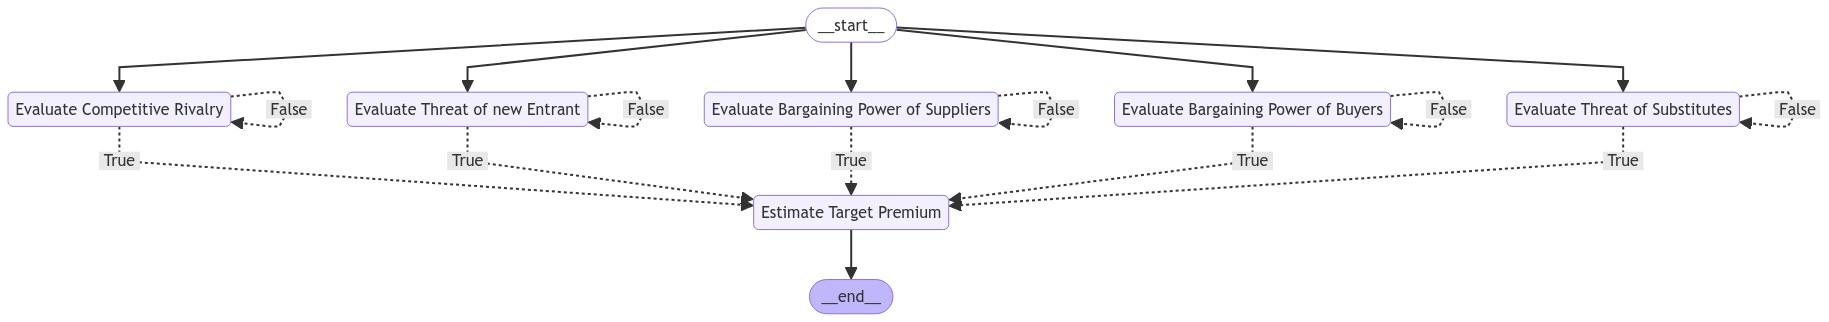

In [9]:
display(Image(ep_graph.get_graph().draw_mermaid_png()))

## Entry Graph

In [10]:
builder = StateGraph(State)
builder.add_node("Lookup Ticker",dummy_node)
builder.add_node("Validate SNP 500", dummy_node)
builder.add_node("Calculate Current Premium", cp_graph)
builder.add_node("Estimate Target Premium", ep_graph)
builder.add_node("Calculate Target Return", dummy_node)
builder.add_edge(START, "Lookup Ticker")

builder.add_edge("Lookup Ticker", "Validate SNP 500")

builder.add_conditional_edges("Validate SNP 500", validate_snp, [
    "Calculate Current Premium",
    "Estimate Target Premium",
    END
])

builder.add_edge("Estimate Target Premium", "Calculate Target Return")
builder.add_edge("Calculate Current Premium", "Calculate Target Return")
    

builder.add_edge("Calculate Target Return", END)
graph = builder.compile()

### Visualize Agent Graph

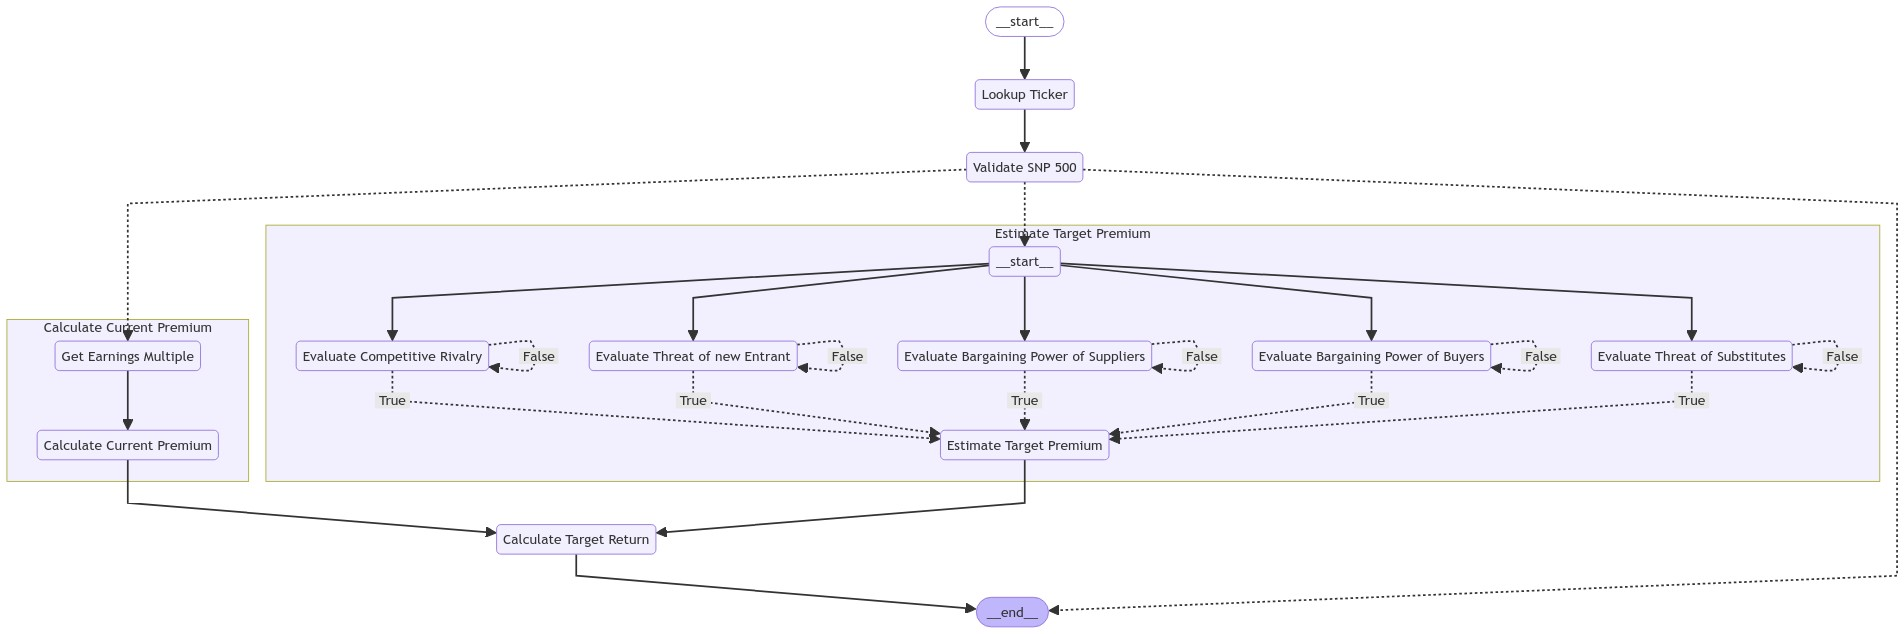

In [11]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))